In [116]:
import pandas as pd
data_files=[
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "hs_directory.csv",
    "graduation.csv",
    "sat_results.csv"]

data={}

for file in data_files:
    d = pd.read_csv("schools/{0}".format(file))
    key_name = file.replace(".csv","")
    data[key_name] = d
    

In [117]:
#print(data["sat_results"].head(5))



In [118]:
#for key in data:
    #print(data[key].head())
    

In [119]:
all_survey=pd.read_csv("schools/survey_all.txt",delimiter="\t",encoding="windows-1252")
d75_survey=pd.read_csv("schools/survey_d75.txt",delimiter="\t",encoding="windows-1252")
#combine above
survey=pd.concat([all_survey,d75_survey],axis=0)
#print(survey.head(3))


In [120]:
survey["DBN"]=survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:,survey_fields]
data["survey"]=survey



In [121]:
#print(survey.head())

In [122]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [123]:
cols=['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 
      'SAT Writing Avg. Score']


for c in cols:
    data["sat_results"][c]=pd.to_numeric(data["sat_results"][c],
                                        errors="coerce")
    
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


print(data['sat_results']['sat_score'].head())        

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


In [124]:
import re

def find_lat(loc):
    coords= re.findall("\(.+\)",loc)
    lat= coords[0].split(",")[0].replace("(", "")
    return lat

data["hs_directory"]["lat"]=data["hs_directory"]["Location 1"].apply(find_lat)

#print(data["hs_directory"].head())

In [125]:
import re

def find_lon(loc):
    coords = re.findall("\(.+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lon"]=data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lon"]=pd.to_numeric(data["hs_directory"]["lon"],errors="coerce")
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"],errors="coerce")


In [126]:
class_size = data["class_size"]

class_size = class_size[class_size["GRADE "]=="09-12"]

class_size = class_size[class_size["PROGRAM TYPE"]=="GEN ED"]

#print(class_size.head())



In [127]:
import numpy as np
class_size = class_size.groupby("DBN").agg(np.mean)

class_size.reset_index(inplace=True)

data["class_size"] = class_size


In [128]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]


In [129]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [130]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col]=pd.to_numeric(data["ap_2010"][col],errors="coerce")
    
print(data["ap_2010"].dtypes)
    

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


In [131]:
combined= data["sat_results"]
combined = combined.merge(data["ap_2010"],on="DBN",how="left")

combined = combined.merge(data["graduation"], on="DBN", how="left")

print(combined.head(5))
print(combined.shape)

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
0                     29                            355.0   
1                     91                            383.0   
2                     70                            377.0   
3                      7                            414.0   
4                     44                            390.0   

   SAT Math Avg. Score  SAT Writing Avg. Score  sat_score  \
0                404.0                   363.0     1122.0   
1                423.0                   366.0     1172.0   
2                402.0                   370.0     1149.0   
3                401.0      

In [132]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

In [133]:
combined= combined.fillna(combined.mean())
combined = combined.fillna(0)



In [134]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)



In [137]:
correlations=combined.corr()
correlations= correlations["sat_score"]
#print(correlations)


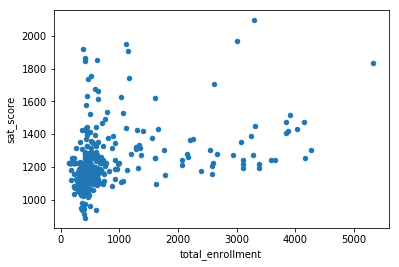

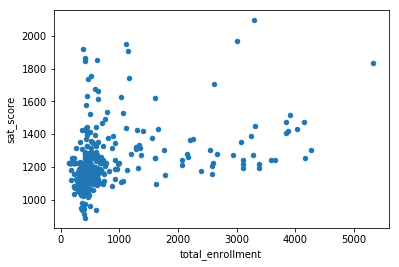

In [139]:
import matplotlib.pyplot as plt

combined.plot.scatter(x="total_enrollment", y="sat_score")
plt.show()

In [145]:
low_enrollment= combined[combined["total_enrollment"]<1000]

low_enrollment =combined[combined["sat_score"]<1000]

print(low_enrollment["School Name"])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


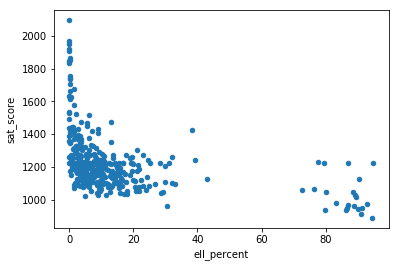

In [146]:
combined.plot.scatter(x='ell_percent', y='sat_score')
plt.show()


In [149]:
districts = combined.groupby("school_dist").agg(np.mean)

districts.reset_index(inplace=True)

print(districts.head())



  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD    ...      \
0                            13

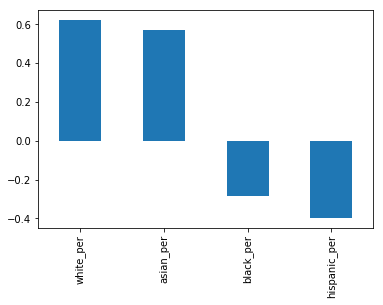

In [151]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()
plt.show()

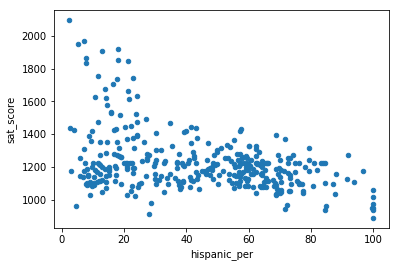

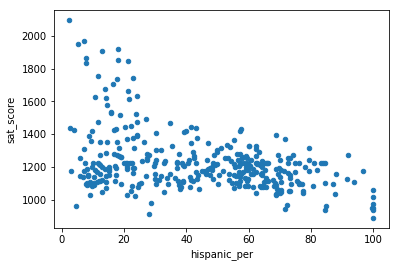

In [153]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.show()

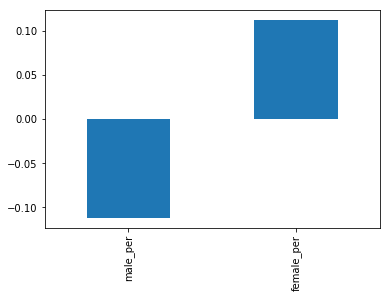

In [155]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()
plt.show()


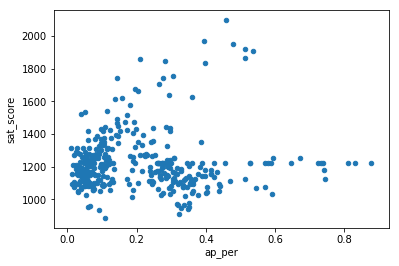

In [158]:
combined["ap_per"] = combined["AP Test Takers "]/ combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()